In [1]:
import os

from IPython.display import Image

import rpy2.robjects as robjects
import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects.functions import SignatureTranslatedFunction

import pandas as pd

from rpy2.robjects import pandas2ri
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter

Unable to determine R home: [WinError 2] 지정된 파일을 찾을 수 없습니다


In [2]:
read_delim = robjects.r('read.delim')
#Reads a space-separated text file and sorts the contents into a Dataframe
#Dataframe: A sequence of rows where each column has the same type
seq_data = read_delim('../sequence.index', header = True, stringsAsFactors = False)
#Names of each variables are stored in the first line (header = True)
#Character vectors are not to be converted to factors (stringsAsFactors = False)

In [3]:
print('This data frame has %d columns and %d rows' % (seq_data.ncol, seq_data.nrow))
print(seq_data.colnames)
#If 'ncol' is called directly, it will output a vector [26], since most data in R is stored as a vector
print('Columns in Python %d ' % robjects.r.ncol(seq_data)[0])
#'ncol' and 'nrow' functions return the length of the column and row in a Dataframe
as_integer = robjects.r('as.integer')
match = robjects.r.match
#Formatting some data which were read as str into int types
my_col = match('READ_COUNT', seq_data.colnames)[0]
print('Type of read count before as.integer: %s' % seq_data[my_col - 1].rclass[0])
#'colnames' is used to rename & replace the column names of the Dataframe in R
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])
print('Type of read count after as.integer: %s' % seq_data[my_col - 1].rclass[0])
#Printing that the datatypes that were input as characters were converted into integers
my_col = match('BASE_COUNT', seq_data.colnames)[0]
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])
#The function of 'match' is similar to 'index' in Python
my_col = match('CENTER_NAME', seq_data.colnames)[0]
seq_data[my_col - 1] = robjects.r.toupper(seq_data[my_col - 1])

robjects.r.assign('seq.data', seq_data)
#Assigning seq_data values to another Dataframe, seq.data --> This will be used in the yri_ceu plots

robjects.r('print(c("Column names in R: ",colnames(seq.data)))')

robjects.r('seq.data <- seq.data[seq.data$WITHDRAWN==0, ]')

robjects.r("seq.data <- seq.data[, c('STUDY_ID', 'STUDY_NAME', 'CENTER_NAME', 'SAMPLE_ID', 'SAMPLE_NAME', 'POPULATION', 'INSTRUMENT_PLATFORM', 'LIBRARY_LAYOUT', 'PAIRED_FASTQ', 'READ_COUNT', 'BASE_COUNT', 'ANALYSIS_GROUP')]")

robjects.r('seq.data$POPULATION <- as.factor(seq.data$POPULATION)')

This data frame has 26 columns and 187720 rows
 [1] "FASTQ_FILE"          "MD5"                 "RUN_ID"             
 [4] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [7] "SUBMISSION_ID"       "SUBMISSION_DATE"     "SAMPLE_ID"          
[10] "SAMPLE_NAME"         "POPULATION"          "EXPERIMENT_ID"      
[13] "INSTRUMENT_PLATFORM" "INSTRUMENT_MODEL"    "LIBRARY_NAME"       
[16] "RUN_NAME"            "RUN_BLOCK_NAME"      "INSERT_SIZE"        
[19] "LIBRARY_LAYOUT"      "PAIRED_FASTQ"        "WITHDRAWN"          
[22] "WITHDRAWN_DATE"      "COMMENT"             "READ_COUNT"         
[25] "BASE_COUNT"          "ANALYSIS_GROUP"     

Columns in Python 26 
Type of read count before as.integer: character
Type of read count after as.integer: integer
 [1] "Column names in R: " "FASTQ_FILE"          "MD5"                
 [4] "RUN_ID"              "STUDY_ID"            "STUDY_NAME"         
 [7] "CENTER_NAME"         "SUBMISSION_ID"       "SUBMISSION_DATE"    
[10] "S

YRI,YRI,YRI,...,STU,STU,STU


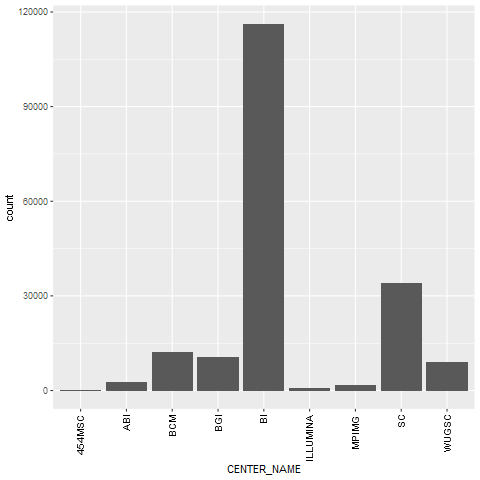

In [4]:
ggplot2.theme = SignatureTranslatedFunction(ggplot2.theme, init_prm_translate = {'axis_text_x': 'axis.text.x'})
#Interpreting the axis.text.x command in R to axis_text_x in Python
bar = ggplot2.ggplot(seq_data) + ggplot2.geom_bar() + ggplot2.aes_string(x='CENTER_NAME') + ggplot2.theme(axis_text_x=ggplot2.element_text(angle = 90, hjust = 1))
#Functions: "geom_bar" - Histogram chart, "CENTER_NAME" - x variable, "element_text(angle = 90, hjust = 1)" - Rotating the text of the x-axis
robjects.r.png('out1.png', type='cairo-png')
bar.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out1.png')

In [5]:
robjects.r('yri_ceu <- seq.data[seq.data$POPULATION %in% c("YRI", "CEU") & seq.data$BASE_COUNT < 2E9 & seq.data$READ_COUNT < 3E7, ]')
#Extracting a separate Dataframe with only the YRI and CEU data while limiting the max base and read counts
yri_ceu = robjects.r('yri_ceu')

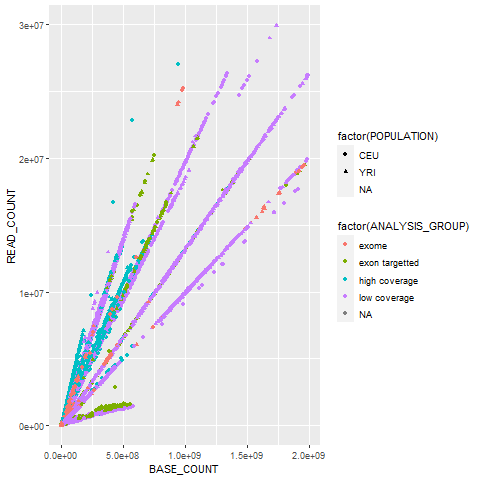

In [6]:
scatter = ggplot2.ggplot(yri_ceu) + ggplot2.aes_string(x='BASE_COUNT', y='READ_COUNT', shape='factor(POPULATION)', col='factor(ANALYSIS_GROUP)') + ggplot2.geom_point()
#Functions: "geom_point" - Scatter plot, "factor(INPUT)" - Input factor to be considered while printing the scatter plot
robjects.r.png('out2.png')
scatter.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out2.png')

In [7]:
#Converting the R Dataframe to pandas via rpy2
pd_yri_ceu = pandas2ri.rpy2py(yri_ceu)  #'ri2py' is obsolete. The new syntax is 'rpy2py'
#print(type(pd_yri_ceu))
#print(pd_yri_ceu)
pandas2ri.activate()    #Required to run 'py2rpy'
del pd_yri_ceu['PAIRED_FASTQ']
no_paired = pandas2ri.py2rpy(pd_yri_ceu)
robjects.r.assign('no.paired',no_paired)
robjects.r("print(colnames(no.paired))")


 [1] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [4] "SAMPLE_ID"           "SAMPLE_NAME"         "POPULATION"         
 [7] "INSTRUMENT_PLATFORM" "LIBRARY_LAYOUT"      "READ_COUNT"         
[10] "BASE_COUNT"          "ANALYSIS_GROUP"     


'STUDY_ID','STUDY_NA...,'CENTER_N...,...,'READ_COU...,'BASE_COU...,'ANALYSIS...
